This file contains the implementation of our Random Forests model with preprocessing and feature engineering techniques applied

In [1]:
# Import statments
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ************************************************** PRE PROCESSING **************************************************

# In this section we apply common preprocessing technniques for our Random Fores, XGBoost and GBM
# ---------------------------- LOAD DATASET -----------------------------
def load_dataset(filename):
  return pd.read_csv(filename)

# ------------------------ HANDLE MISSING VALUES ------------------------
def process_empty_values(data):
    for column in data.columns:
        if pd.api.types.is_numeric_dtype(data[column]): # Checking if the cols data type is numeric: either integer or float
            data[column] = data[column].fillna(data[column].mean()) # Assign 'fillna' operation directly to the DataFrame col
        else:  # Assume the col is categorical
            # Handle the situation where the mode calc returns an empty series
            mode_value = data[column].mode()
            if not mode_value.empty:
                data[column] = data[column].fillna(mode_value[0])
            else:
                data[column] = data[column].fillna('Unknown') # If all values are NaN we fill it with a placeholder
    return data

# --------------------------- LABEL ENCODING ---------------------------
# This function assigns unique int to each category, which replaces the original categorical values with numerical values
# Important because the model only works with numerical vals
# Room for improvement (functions couldve not been hardcoded)
def label_encoding(data):
    label_encoder = LabelEncoder()
    data['merchant'] = label_encoder.fit_transform(data['merchant'])
    data['category'] = label_encoder.fit_transform(data['category'])
    return data

# -------------------------- FEATURE SELECTION --------------------------
# This function drops al unnecessary columns
# Room for improvement (functions couldve not been hardcoded)
def drop_unnecessary_cols(data):
  data = data.iloc[:, 1:] 
  cols_to_drop = ['first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'job', 'dob', 'trans_num', 'unix_time']
  data = data.drop(cols_to_drop, axis=1)
  return data

# ---------------------------- ARE NUMERIC ----------------------------
# This function doucle checks that all the vals in out dataset are numeric
def identify_non_numeric_columns(data):
    non_numeric_cols = data.select_dtypes(exclude=['int', 'float', 'int64', 'float64', 'uint8']).columns # ID non numeric cols by checking theyre corresponding data types
    # Print and return the non numeric cols
    if len(non_numeric_cols) > 0:
        print("Non-numeric columns identified:", non_numeric_cols)
    else:
        print("All columns are numeric.")
    return list(non_numeric_cols)

# ------------------ EXPAND trans_date_trans_time FEAT------------------
# This function strictly converts the trans_date_trans_time feature
# Since trans_date_trans_time is a very complicated feaat (it includes several features)
# We decided to split them up to use for feature engineering
def expand_datetime_features(data, datetime_col):
    # Converting the datetime
    data[datetime_col] = pd.to_datetime(data[datetime_col], format="%m/%d/%y %H:%M")
    # Extract components from the datetime column
    data['Year'] = data[datetime_col].dt.year
    data['Month'] = data[datetime_col].dt.month
    data['Day'] = data[datetime_col].dt.day
    data['Hour'] = data[datetime_col].dt.hour
    data['Minute'] = data[datetime_col].dt.minute
    data['Second'] = data[datetime_col].dt.second
    data['Unix_Timestamp'] = data[datetime_col].astype(int) / 10**9
    data.drop(columns=[datetime_col], inplace=True)
    return data

In [3]:
# ************************************************ FEATURE ENGINEERING ************************************************
# In this section we apply feature engieering by creating new columns that will help detect fraudulent activites

# This fucntion takwes in the dataset and the features: 'lat', 'long', 'merch_lat', 'merch_long' in order to
# calculate the distance between were the transaction was made and where the customer lives 
def calc_distance_of_purchase(data, lat1_col, long1_col, lat2_col, long2_col, drop_cols=True):
    # Convertind the latitude and longgitude from degrees to radians:
    lat1, lon1 = np.radians(data[lat1_col]), np.radians(data[long1_col])
    lat2, lon2 = np.radians(data[lat2_col]), np.radians(data[long2_col])
    # Applying the Haversine formula:
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    R = 6371.0 # Earth radius in kilometers (approx. 6371 km)
    data['distance'] = R * c
    # Dropping the original latitude and longitude columns since we dont want it messing with our results now that its converted into a desired, nore useful val
    if drop_cols:
        data.drop(columns=[lat1_col, long1_col, lat2_col, long2_col], inplace=True)
    return data

# This function is used to calculate the average amount of money spent in transactions for each credit card in the dataset.
# Once we have the average, we will use it to compare each transaction amount to the average and can help identify transactions that are too high.
def add_average_transaction_per_card_feature(data, card_column, amount_column):
    averages = data.groupby(card_column)[amount_column].mean().reset_index(name='avg_amt_per_card')# Calculating the avg transaction amt per card
    data = data.merge(averages, on=card_column, how='left') # Merging the avg back into the original dataframe
    data['amt_vs_avg'] = data[amount_column] / data['avg_amt_per_card'] # Creating the new feature by comparing each transaction amt to the avg
    return data

# This function is used to count how many transactions are made each day per credit card, which 
# helps detect unusual activity if there are more transactions per day than the usual pattern.
def add_transaction_frequency_per_card(data, card_col, year_col, month_col, day_col):
    if 'date' not in data.columns:
        data['date'] = pd.to_datetime(data[[year_col, month_col, day_col]])
    transaction_counts = data.groupby([card_col, 'date']).size().reset_index(name='daily_transactions')
    data = data.merge(transaction_counts, on=[card_col, 'date'], how='left')
    return data

# This function is used to calculate the number of days between each transaction for the same credit card. Helps detect a pattern of how frequently the card is being used; 
# for example, if the card is used 2-3 times a day and all of a sudden, the card is being used 10 times a day for 2 days straight, it could be fraud.
def add_days_since_last_purchase(data, card_col, date_col):
    data[date_col] = pd.to_datetime(data[date_col])
    data = data.sort_values(by=[card_col, date_col])
    data['days_since_last_purchase'] = data.groupby(card_col)[date_col].diff().dt.days
    data['days_since_last_purchase'] = data['days_since_last_purchase'].fillna(-1).astype(int)
    data.drop(date_col, axis=1, inplace=True)
    return data

# This function is used to compare the current transaction amount to the average amount spent for a similar category. 
# By detecting significant deviations in spending patterns per category we can detect fraud. (after encoding the category val)
def add_spending_pattern_change(data, card_col, category_col, amount_col):
    avg_spending = data.groupby([card_col, category_col])[amount_col].mean().reset_index() # Calc the avg amt spent per card & category
    avg_spending.columns = [card_col, category_col, 'avg_amt_per_card_and_category']
    data = pd.merge(data, avg_spending, how='left', on=[card_col, category_col])  # Merging it back to the original dataset to associate the avg with ea transaction
    data['spending_pattern_change'] = data[amount_col] - data['avg_amt_per_card_and_category'] # Calc the diff between the transaction amt and the avg amt
    return data

# This function takes in the card number and the merchant feat (after encoding) to calculate if this is the first time a person
# has visited the merchant and the total num of unique merchats the person has used the card in
# Returns 2 cols: first_time_merchant and unique_merchants
def add_merchant_visit_features(data, card_col, merchant_col):
    # Track the first occurrence of a merchant for each card
    # Convert boolean to integer explicitly to ensure correct data type.
    data['first_time_merchant'] = data.duplicated(subset=[card_col, merchant_col], keep='first').astype(int)
    # Count of unique merchants visited by each card
    # Already numerical since it's a count, but we ensure it's recognized as an integer.
    unique_merchants = data.groupby(card_col)[merchant_col].transform('nunique').astype(int)
    data['unique_merchants'] = unique_merchants    
    return data

# This function is used to categorize the hout of the day (using the 'Hour' feat) into 'Night', 'Morning', 'Afternoon', 'Evening'
def categorize_time_of_day(data):
    bins = [0, 6, 12, 18, 24]  # Defining the time ranges 
    labels = ['Night', 'Morning', 'Afternoon', 'Evening']
    data['time_of_day'] = pd.cut(data['Hour'], bins=bins, labels=labels, right=False)
    data['time_of_day'] = LabelEncoder().fit_transform(data['time_of_day']) # After conversion it encodes those variables
    return data

In [4]:
# ------------------------------ LOAD DATA ------------------------------
# The dataset this function is calling only contains 250,000 samples
# If you would like to test using the entire dataset containing 1,000,000+ samples, change to fraudTrain.csv
train_data = load_dataset('../fraudTrain.csv')

# --------------------------- PREPROCESS DATA ---------------------------
train_data = process_empty_values(train_data)
train_data = label_encoding(train_data)
train_data = drop_unnecessary_cols(train_data)
train_data = expand_datetime_features(train_data, 'trans_date_trans_time')

# ------------------------- FEATURE ENGINEERING --------------------------
train_data = calc_distance_of_purchase(train_data, 'lat', 'long', 'merch_lat', 'merch_long')
train_data = add_average_transaction_per_card_feature(train_data, 'cc_num', 'amt')
train_data = add_transaction_frequency_per_card(train_data, card_col='cc_num', year_col='Year', month_col='Month', day_col='Day')
train_data = add_days_since_last_purchase(train_data, card_col='cc_num', date_col='date')
train_data = add_spending_pattern_change(train_data, card_col='cc_num', category_col='category', amount_col='amt')
train_data = add_merchant_visit_features(train_data, card_col='cc_num', merchant_col='merchant')
train_data = categorize_time_of_day(train_data)

# # ------------------------- LAST MINUTE CHECKS --------------------------
non_numeric_columns = identify_non_numeric_columns(train_data) # Used to double check that all our values are numeric
# Dropping last miinute - not as useful- cols 
columns_to_drop = ['Minute', 'Second']
train_data = train_data.drop(columns=columns_to_drop, axis=1)

# # ----------------------------- SPLIT DATA ------------------------------
# Split data into features and target
X = train_data.drop("is_fraud", axis=1)
y = train_data["is_fraud"]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

All columns are numeric.


In [5]:
# ----------------------------- TRAIN MODEL -----------------------------
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42) # Creating a Random Forest classifier
rf_classifier.fit(X_train, y_train) # Training the classifier on the training data
y_pred = rf_classifier.predict(X_test) # Making predictions on the test data
print("Model Trained Successfully")

Model Trained Successfully


---------- Classification Report: ----------
Accuracy: 0.998120018799812
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99383
           1       0.96      0.72      0.83       618

    accuracy                           1.00    100001
   macro avg       0.98      0.86      0.91    100001
weighted avg       1.00      1.00      1.00    100001

---------- Confusion Matrix: ----------


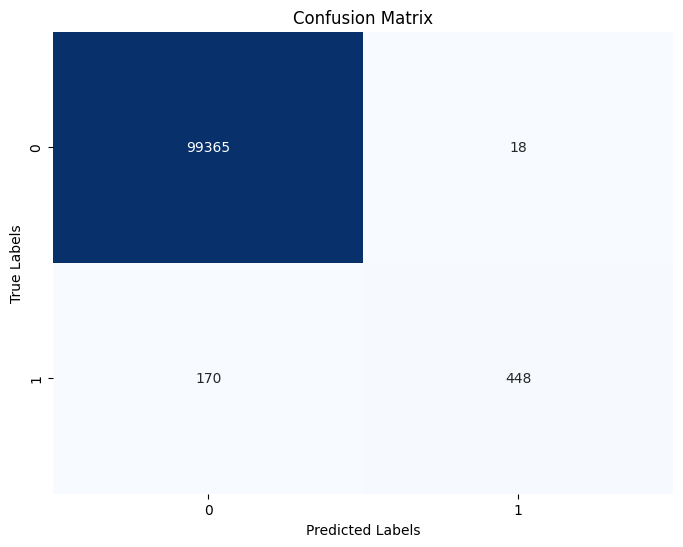

In [6]:
print("---------- Classification Report: ----------")
# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Get a detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("---------- Confusion Matrix: ----------")
# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()